In [1]:
!date

Tue Mar 29 06:28:39 EDT 2022


In [2]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [3]:
%%time

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *

import umap

CPU times: user 10.9 s, sys: 5.24 s, total: 16.1 s
Wall time: 32.8 s


In [4]:
analysis_name = 'CVAE_2022-03-25 18:28:49.469238'
save_dir = os.path.join('../Assets/tf_weights',analysis_name)

In [5]:
def dummy_ordinal(invec):
    unique_values = np.unique(invec)
    new_values = np.arange(1,len(unique_values)+1)
    new_arr = [new_values[val==unique_values][0] for val in invec]
    return new_arr

In [6]:
def flatten_cmat(cmats):
    ns = cmats.shape[0]
    ni = cmats.shape[-1]
    tridx = np.triu_indices(n=ni,k=1)
    mat_flat = np.array([cmats[i,:,:][tridx] for i in range(ns)])
    return mat_flat

In [7]:
# YEO ROI NAMES
rnames = ['LH-Vis-EVC','LH-SomMot-Mot','LH-DorsAttn-Post','LH-DorsAttn-FEF','LH-DorsAttn-PrCv','LH-SalVentAttn-ParOper','LH-SalVentAttn-TempOcc','LH-SalVentAttn-FrOper','LH-SalVentAttn-PFCl','LH-SalVentAttn-Med','LH-Limbic-OFC','LH-Limbic-TempPole','LH-Cont-Par','LH-Cont-Temp','LH-Cont-PFCd','LH-Cont-PFCl','LH-Cont-OFC','LH-Cont-PFCv','LH-Cont-pCun','LH-Cont-Cing','LH-Cont-PFCmp','LH-Default-Par','LH-Default-Temp','LH-Default-PFC','LH-Default-PCC','LH-Default-PHC','RH-Vis-EVC','RH-SomMot-Mot','RH-DorsAttn-Post','RH-DorsAttn-FEF','RH-DorsAttn-PrCv','RH-SalVentAttn-TempOccPar','RH-SalVentAttn-PrC','RH-SalVentAttn-FrOper','RH-SalVentAttn-PFCv','RH-SalVentAttn-PFCl','RH-SalVentAttn-Med','RH-Limbic-OFC','RH-Limbic-TempPole','RH-Cont-Par','RH-Cont-Temp','RH-Cont-PFCv','RH-Cont-PFCl','RH-Cont-pCun','RH-Cont-Cing','RH-Cont-PFCmp','RH-Default-Par','RH-Default-Temp','RH-Default-PFCv','RH-Default-PFCm','RH-Default-PCC']

In [8]:
df = pd.read_csv('../Data/comb_df.csv')
df['dataset_id'] = dummy_ordinal(df['dataset'])
df['site_id'] = dummy_ordinal(df['site'])

patients = df['diag'].values==1
df_asd = df.iloc[patients]
df_td = df.iloc[~patients]

print(df_asd.shape)
print(df_td.shape)

df

(661, 15)
(841, 15)


,Unnamed: 0,participant_id,diag,age,sex,fiq,site,DSMIV,ados_total,ados_social,ados_comm,ados_rrb,dataset,dataset_id,site_id
0,0,50002,1,16.77,1,103.0,13,1.0,12.0,8.0,4.0,3.0,ABIDE I,1,4
1,2,50004,1,19.09,1,113.0,13,1.0,18.0,12.0,6.0,2.0,ABIDE I,1,4
2,3,50005,1,13.73,2,119.0,13,1.0,12.0,8.0,4.0,1.0,ABIDE I,1,4
3,4,50006,1,13.37,1,109.0,13,1.0,12.0,8.0,4.0,4.0,ABIDE I,1,4
4,9,50011,1,16.93,1,111.0,13,1.0,13.0,9.0,4.0,NaN,ABIDE I,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,746,30163,2,8.00,2,136.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29
1498,747,30164,2,10.00,2,115.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29
1499,748,30165,2,12.00,2,120.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29
1500,749,30166,2,10.00,2,112.0,ABIDEII-OHSU_1,NaN,NaN,NaN,NaN,NaN,ABIDE II,2,29


In [9]:
## Load Data
cmats = np.load('../Data/cmats_r51_S1502.npz')['data']
cmats_rel = np.load('../Data/rel-cmats_r51_S1502.npz')['data']
cmats_asd_flat = flatten_cmat(cmats[patients,:,:])

print(cmats.shape)
print(cmats_rel.shape)
print(cmats_asd_flat.shape)

(1502, 51, 51)
(1502, 2, 51, 51)
(661, 1275)


In [10]:
def depad(mat,idx=(6,57)):
    'depads the cmats'
    if mat.ndim==3:
        mat_trimmed = mat[:,idx[0]:idx[1],idx[0]:idx[1]]
    elif mat.ndim==4:
        mat_trimmed = mat[:,:,idx[0]:idx[1],idx[0]:idx[1]]
    else:
        print(mat.shape)
        raise Exception("Not implemented")
        
    return mat_trimmed

In [11]:
%%time

data = np.load(os.path.join(save_dir,'results.npz'))
data = dict(data)
data_keys = list(data.keys())

# Z_mu = data['Z_mu']
# Z_sigma = data['Z_sigma']
# Z = data['Z']
# S_mu = data['S_mu']
# S_sigma = data['S_sigma']
# S = data['S']
# Z_sample100 = data['Z_sample100']
# S_sample100 = data['S_sample100']

data['recon_td_mu'] = depad(data['recon_td_mu'])
data['recon_asd_mu'] = depad(data['recon_asd_mu'])
data['recon_twin_mu'] = depad(data['recon_twin_mu'])
data['recon_td_samples'] = depad(data['recon_td_samples'])
data['recon_asd_samples'] = depad(data['recon_asd_samples'])
data['recon_twin_samples'] = depad(data['recon_twin_samples'])

data['Z_asd_sample10'] = data['Z_sample100'][0:10,patients,:]
data['S_asd_sample10'] = data['S_sample100'][0:10,patients,:]

for key in data_keys:
    print(f'{key.center(20)} | {data[key].shape}')

        Z_mu         | (1502, 16)
      Z_sigma        | (1502, 16)
         Z           | (1502, 16)
        S_mu         | (1502, 16)
      S_sigma        | (1502, 16)
         S           | (1502, 16)
    Z_sample100      | (100, 1502, 16)
    S_sample100      | (100, 1502, 16)
    recon_td_mu      | (841, 51, 51)
    recon_asd_mu     | (661, 51, 51)
   recon_twin_mu     | (661, 51, 51)
  recon_td_samples   | (100, 841, 51, 51)
 recon_asd_samples   | (100, 661, 51, 51)
 recon_twin_samples  | (100, 661, 51, 51)
CPU times: user 20 s, sys: 918 ms, total: 20.9 s
Wall time: 21 s


In [12]:
def plot_nice_bar(key,rsa,ax=None,figsize=None,dpi=None,fontsize=None,fontsize_star=None,fontweight=None,line_width=None,marker_size=None,title=None,report_t=False,do_pairwise_stars=False,do_one_sample_stars=True):
    
    import seaborn as sns
    from scipy.stats import ttest_1samp
    from scipy.stats import ttest_ind as ttest
    
    pallete = sns.color_palette()
    pallete_new = sns.color_palette()
    
    if not figsize:
        figsize = (5,2)
    if not dpi:
        dpi = 300
        
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=figsize,dpi=dpi)

    pallete_new[1]=pallete[0]
    pallete_new[0]=pallete[1]
    pallete_new[0] = tuple(np.array((.5,.5,.5)))

    data=rsa[key]
    n = data.shape[0]
    c = data.shape[1]
    x = np.arange(c)
    
    if not fontsize:
        fontsize = 16
        
    if not fontsize_star:
        fontsize_star = 25
    if not fontweight:        
        fontweight = 'bold'
    if not line_width:    
        line_width = 2.5
    if not marker_size:            
        marker_size = .1
    


    for i in range(c):
        plot_data = np.zeros(data.shape)
        plot_data[:,i] = data[:,i]

        xs = np.repeat(i,n)+(np.random.rand(n)-.5)*.25
        sc = plt.scatter(xs,data[:,i],c='k',s = marker_size)
        b = sns.barplot(data=plot_data,errcolor='r',linewidth=line_width,errwidth=line_width,facecolor=np.hstack((np.array(pallete_new[i]),.3)),edgecolor=np.hstack((np.array(pallete_new[i]),1)))

    locs, labels = plt.yticks()  
    new_y = locs
    new_y = np.linspace(locs[0],locs[-1],6)
    plt.yticks(new_y,labels=[f'{yy:.2f}' for yy in new_y],fontsize=fontsize,fontweight=fontweight)
    plt.ylabel('model fit (r)',fontsize=fontsize,fontweight=fontweight)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(line_width)

    xlbls = ['CMAT','BG','SL']
    plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight)
    
    if do_one_sample_stars:
        one_sample = np.array([ttest_1samp(data[:,i],0) for i in range(3)])
        one_sample_thresh = np.array((1,.05,.001,.0001))
        one_sample_stars = np.array(('n.s.','*','**','***'))
        xlbls = ['CMAT','BG','SL']
        for i in range(1,c):
            these_stars = one_sample_stars[max(np.nonzero(one_sample[i,1]<one_sample_thresh)[0])]
            xlbls[i] = f'{xlbls[i]}\n({these_stars})'
        plt.xticks(np.arange(3),labels=xlbls,fontsize=fontsize,fontweight=fontweight,horizontalalignment='center',multialignment='center')

    pairwise_t = np.zeros((3,3))
    pairwise_p = np.zeros((3,3))

    pairwise_sample_thresh = np.array((1,.05,.001,.0001))
    pairwise_sample_stars = np.array(('n.s.','*','**','***'))

    if report_t:
        for i in range(c):
            for j in range(c):
                t,p = ttest(data[:,i],data[:,j])
                mnames = ['CMAT','BG','SL']

                if p > .001:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p = {p:.2f}')
                else:
                    print(f'{key} {mnames[i]} >  {mnames[j]} | t({data.shape[0]-1}) = {t:.2f} p $<$ .001')
                pairwise_t[i,j] = t
                pairwise_p[i,j] = p

    comps = [[1,2]]
    if do_pairwise_stars:
        for comp_idx in range(len(comps)):
            this_comp = comps[comp_idx]
            sig_idx = max(np.nonzero(pairwise_p[this_comp[0],this_comp[1]]<pairwise_sample_thresh)[0])
            max_y = new_y[-1] + comp_idx*.05
            xs = np.array(this_comp)
            stars = pairwise_sample_stars[sig_idx]
            plt.plot(xs,[max_y,max_y],'k',linewidth=line_width)
            plt.text(xs.mean(),max_y,stars,fontsize=fontsize_star,horizontalalignment='center',fontweight=fontweight)
        
    ylim = plt.ylim()
    plt.ylim(np.array(ylim)*(1,1.1))
    
    if not title:
        plt.title(key,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)    
    else:
        plt.title(title,fontsize=fontsize*1.5,pad=2,fontweight=fontweight)

In [13]:
def key_rsa(key,data_scale='ratio',return_models=True):
    
    z = data['Z_asd_sample10']
    s = data['S_asd_sample10']
    c = cmats_asd_flat

    vec = df_asd[key].values
    e = np.isnan(vec)

    model_rdm = make_RDM(vec[~e],data_scale=data_scale, metric='euclidean')
    bg_rdm = np.array([make_RDM(z[i,~e,:],data_scale='ratio', metric='euclidean') for i in range(z.shape[0])])
    sl_rdm = np.array([make_RDM(s[i,~e,:],data_scale='ratio', metric='euclidean') for i in range(z.shape[0])])
    c_rdm = np.array([make_RDM(c[~e,:],data_scale='ratio', metric='correlation') for i in range(z.shape[0])])
    
    models = dict
    models.update({'model_rdm' : model_rdm})
    models.update({'bg_rdm' : bg_rdm})
    models.update({'sl_rdm' : sl_rdm})
    models.update({'c_rdm' : c_rdm})

    bg_fit = [fit_rsa(bg_rdm[i,:,:],model_rdm) for i in range(10)]
    sl_fit = [fit_rsa(sl_rdm[i,:,:],model_rdm) for i in range(10)]
    c_fit = [fit_rsa(c_rdm[0,:,:],model_rdm) for i in range(10)]

    res = np.array((c_fit,bg_fit,sl_fit)).transpose()

    return res

In [14]:
rsa_res = dict()
keys = ['dataset_id', 'site_id','age', 'sex', 'fiq','DSMIV','ados_total', 'ados_social', 'ados_comm', 'ados_rrb']
data_scale = ['ordinal', 'ordinal','ratio', 'ordinal', 'ratio','ordinal','ratio', 'ratio', 'ratio', 'ratio']

for i in tqdm(range(len(keys))):
    rsa_res.update({keys[i] : key_rsa(keys[i],data_scale=data_scale[i])})

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


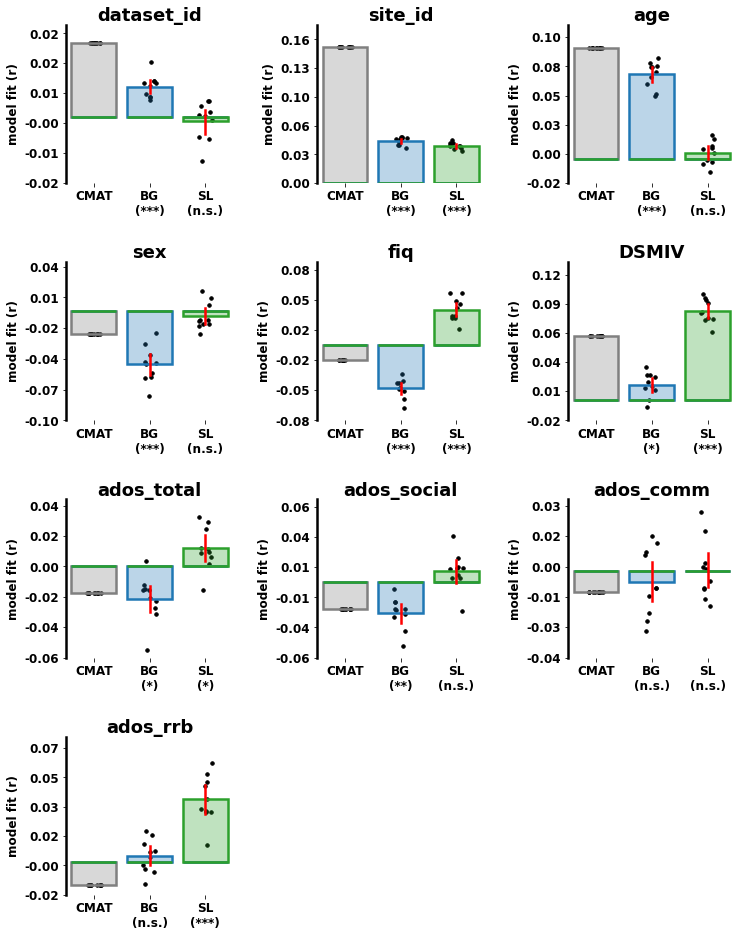

In [15]:
ncols = 3
nrows = int(np.ceil(len(keys)/3))
plt.figure(figsize=np.array((ncols,nrows))*4)

for i,key in enumerate(keys):
    ax = plt.subplot(nrows,ncols,i+1)
    plot_nice_bar(key,rsa_res,
                  ax=ax,figsize=None,
                  dpi=300,fontsize=12,
                  fontsize_star=12,
                  fontweight='bold',
                  line_width=2.5,
                  marker_size=12,title=keys[i])
    
plt.subplots_adjust(
    left=None,
    bottom=None,
    right=None,
    top=None,
    wspace=.5,
    hspace=.5)

In [16]:
def get_bic(inMat,k,covariance_type='full'):
    from sklearn.mixture import GaussianMixture as gmm
    
    model = gmm(n_components=k,covariance_type=covariance_type)
    model.fit(inMat)
    return model.bic(inMat)

def get_bic_range(inMat,ks,covariance_type='full'):
    return [get_bic(inMat,k=i,covariance_type=covariance_type) for i in ks]

def norm(vec):
    return (vec - vec.min()) / (vec.max()-vec.min())

In [17]:
bic_z = np.array([get_bic_range(data['Z_mu'][patients,:],np.arange(2,11)) for i in tqdm(range(100))])
bic_s = np.array([get_bic_range(data['S_mu'][patients,:],np.arange(2,11)) for i in tqdm(range(100))])

100%|██████████| 100/100 [02:49<00:00,  1.69s/it]


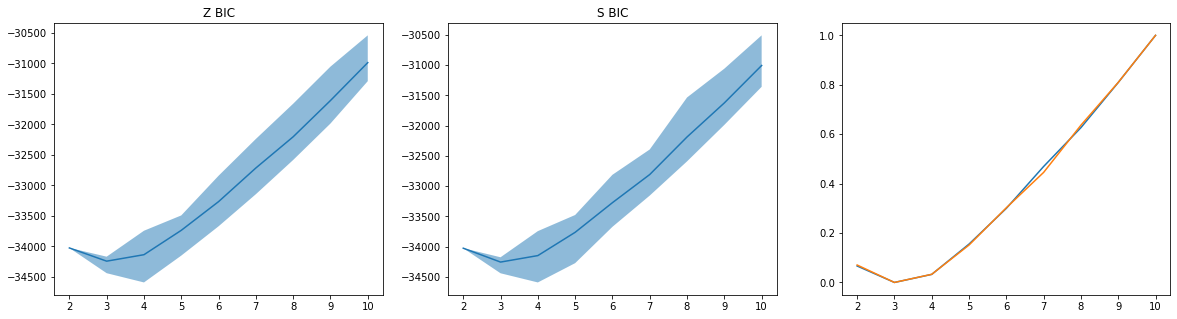

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1);
plt.plot(bic_z.mean(axis=0))
plt.fill_between(np.arange(9),y1=bic_z.min(axis=0),y2=bic_z.max(axis=0),alpha=.5)
plt.title('Z BIC');
plt.xticks(np.arange(9),labels=np.arange(2,11));


plt.subplot(1,3,2);
plt.plot(bic_s.mean(axis=0))
plt.fill_between(np.arange(9),y1=bic_s.min(axis=0),y2=bic_s.max(axis=0),alpha=.5)
plt.title('S BIC');
plt.xticks(np.arange(9),labels=np.arange(2,11));

plt.subplot(1,3,3)
plt.plot(norm(bic_z.mean(axis=0)))
plt.plot(norm(bic_s.mean(axis=0)))
plt.xticks(np.arange(9),labels=np.arange(2,11));

In [19]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# c_idx_s = KMeans(n_clusters=3).fit_predict(data['S_mu'][patients,:])
# c_idx_z = KMeans(n_clusters=3).fit_predict(data['Z_mu'][patients,:])
# adjusted_rand_score(c_idx_s,c_idx_z)

In [320]:
diffmat = abs((data['recon_asd_mu']-data['recon_twin_mu']))

In [321]:
diff_sim = np.corrcoef(flatten_cmat(diffmat))
diff_sim[np.isnan(diff_sim)]=0

/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/data/aglinska/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


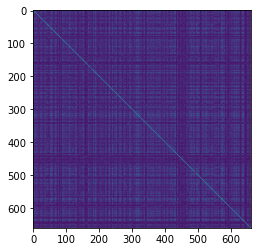

In [322]:
plt.imshow(diff_sim)

In [209]:
bic_d = np.array([get_bic_range(diff_sim,np.arange(2,101),covariance_type='spherical') for i in tqdm(range(10))])

100%|██████████| 10/10 [03:06<00:00, 18.62s/it]


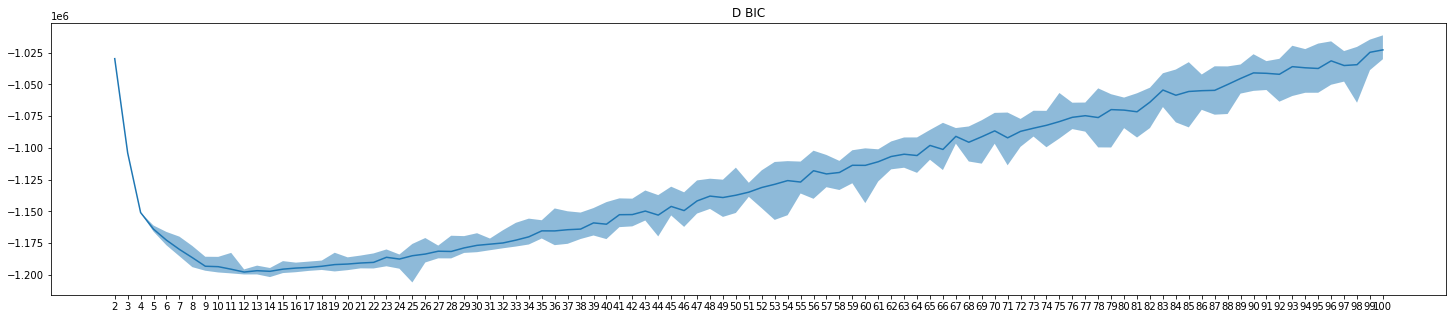

In [215]:
plt.figure(figsize=(25,5))
plt.plot(bic_d.mean(axis=0))
plt.fill_between(np.arange(bic_d.shape[1]),y1=bic_d.min(axis=0),y2=bic_d.max(axis=0),alpha=.5)
plt.title('D BIC');
plt.xticks(np.arange(bic_d.shape[1]),labels=np.arange(2,2+bic_d.shape[1]));

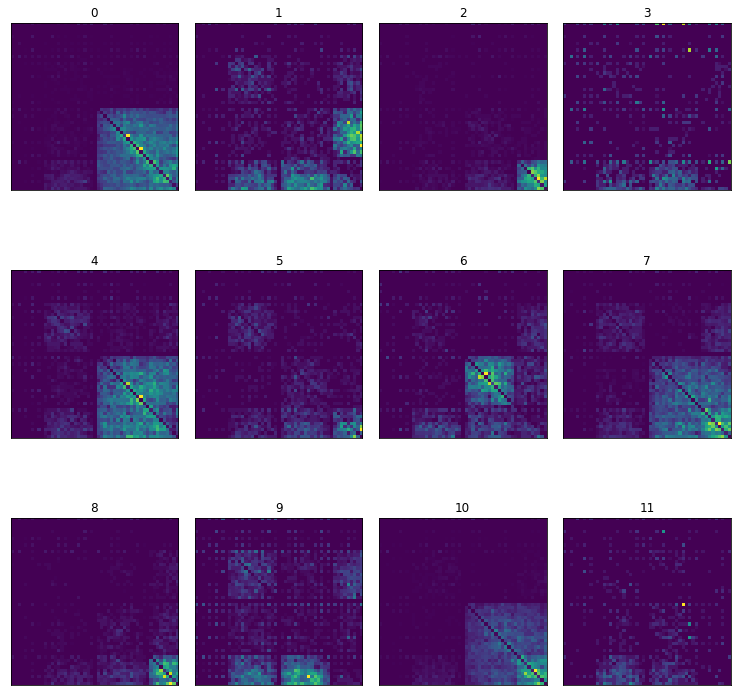

In [319]:
#c_idx_s = KMeans(n_clusters=3).fit_predict(PCA(n_components=5).fit_transform(flatten_cmat(diffmat)))
c_idx_s = KMeans(n_clusters=12).fit_predict(diff_sim)
uc = np.unique(c_idx_s)

plt.figure(figsize=(20,20))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(diffmat[c_idx_s==uc[i],:,:].mean(axis=0))
    plt.xticks([]);plt.yticks([]);
    plt.title(i)
    #plt.colorbar()

#plt.subplot(1,3,2)
#plt.imshow(diffmat[c_idx_s==1,:,:].mean(axis=0))
#plt.colorbar()

#plt.subplot(1,3,3)
#plt.imshow(diffmat[c_idx_s==2,:,:].mean(axis=0))
#plt.colorbar()

#plt.tight_layout()
plt.subplots_adjust(
    left=0,
    bottom=0,
    right=0.5,
    top=0.5,
    wspace=0.1,
    hspace=0.1)

<AxesSubplot:>

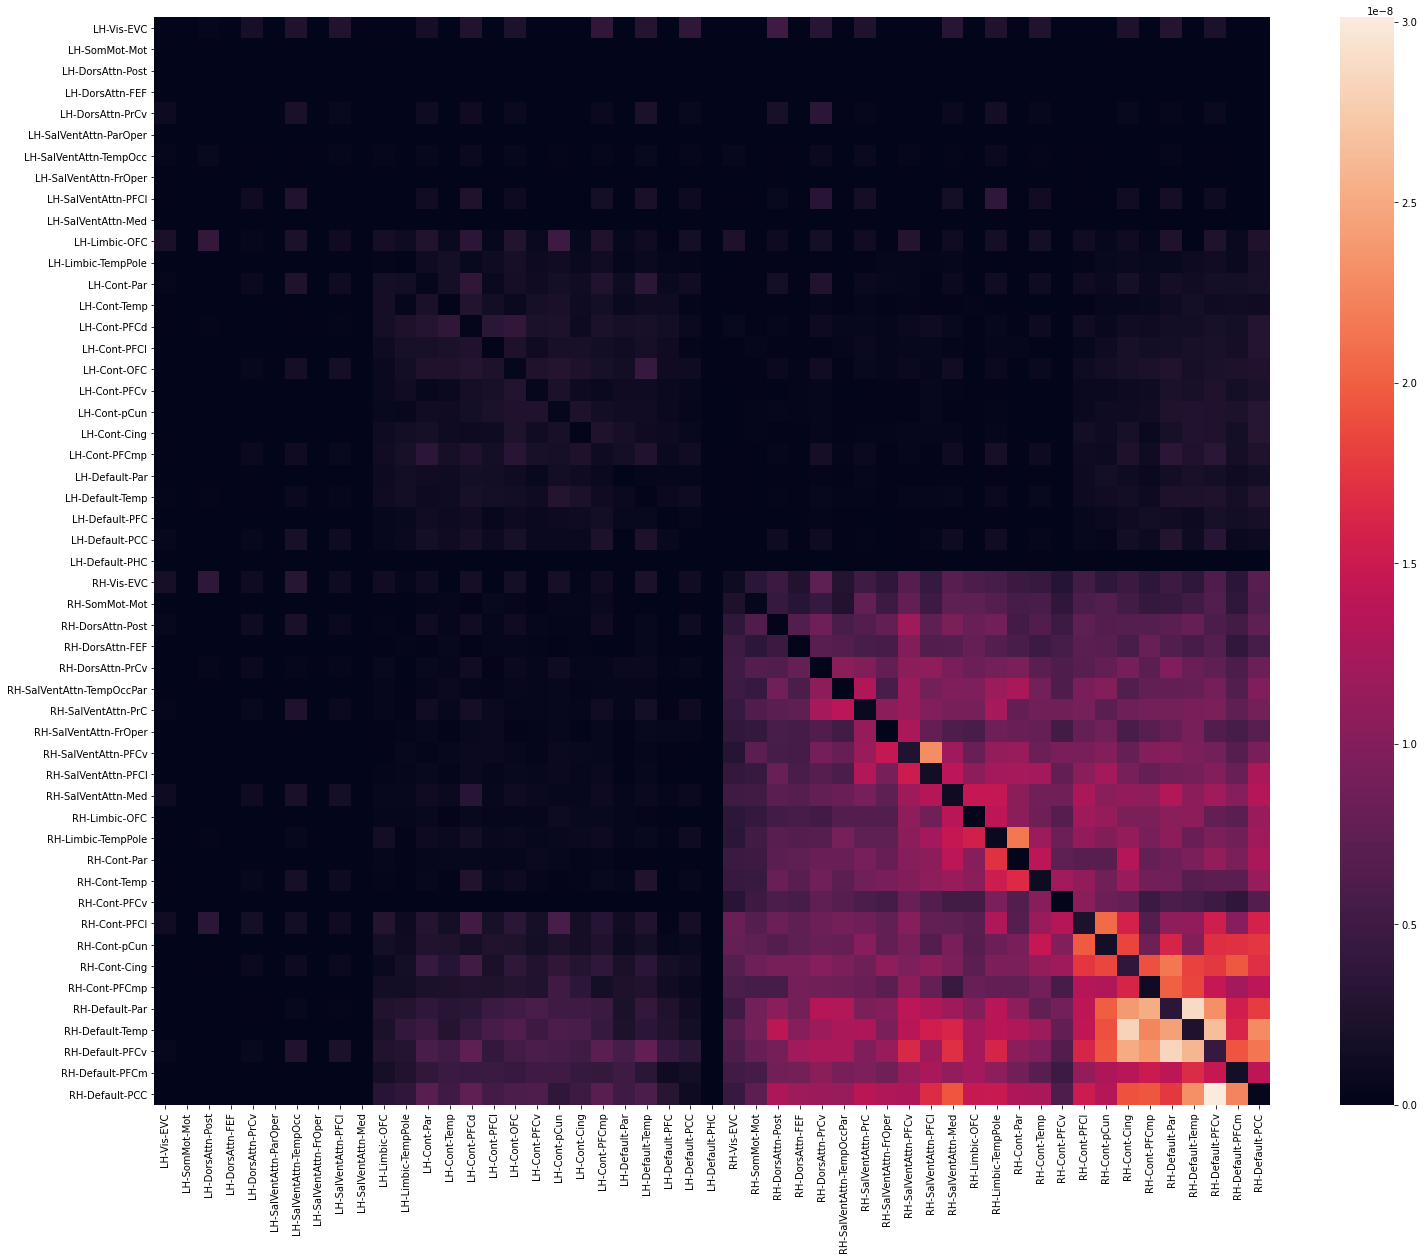

In [93]:
plt.figure(figsize=(25,20))
sns.heatmap(diffmat.mean(axis=0),xticklabels=rnames,yticklabels=rnames)

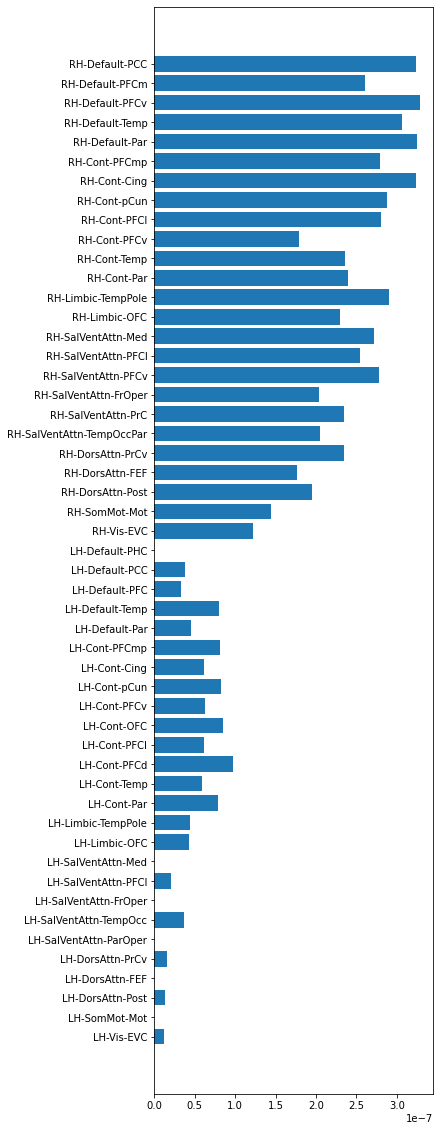

In [94]:
ys = abs(diffmat).sum(axis=1).mean(axis=0)
xs = np.arange(len(ys))

plt.figure(figsize=(5,20))
plt.barh(xs,ys)
plt.yticks(xs,labels=rnames,rotation=0);

In [95]:
from scipy.stats import ttest_1samp

In [96]:
tmat = np.zeros((51,51))
pmat = np.zeros((51,51))
for i in range(51):
    for j in range(51):
        t_res = ttest_1samp(diffmat[:,i,j],0)
        tmat[i,j] = t_res[0]
        pmat[i,j] = t_res[1]

<ipython-input-121-61614464e04e>:4: RuntimeWarning: invalid value encountered in less
  plt.imshow(pmat<.001*51)


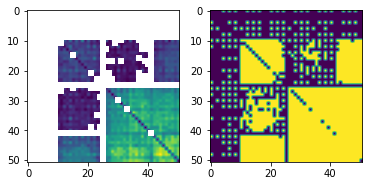

In [121]:
plt.subplot(1,2,1)
plt.imshow(abs(tmat))
plt.subplot(1,2,2)
plt.imshow(pmat<.001*51)

In [99]:
idx_lh = np.array([rname.startswith('LH') for rname in rnames])
idx_rh = np.array([rname.startswith('RH') for rname in rnames])

([<matplotlib.axis.XTick at 0x154bb337a6a0>,
 [Text(0, 0, 'LH'), Text(1, 0, 'RH')])

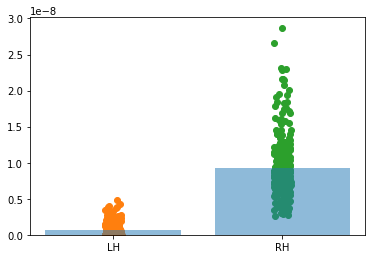

In [120]:
v1 = abs(flatten_cmat(diffmat[:,idx_lh,:][:,:,idx_lh])).mean(axis=0)
v2 = abs(flatten_cmat(diffmat[:,idx_rh,:][:,:,idx_rh])).mean(axis=0)
plt.bar([0,1],[v1.mean(),v2.mean()],alpha=.5)

ys = v1
xs = np.ones(ys.shape)*0
xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
plt.scatter(xs,ys)

ys = v2
xs = np.ones(ys.shape)*1
xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
plt.scatter(xs,ys)

plt.xticks([0,1],labels=['LH','RH'])

In [145]:
def plot_scatterbar(inData,lbls):
#inData = [v1,v2]
#lbls = ['LH','RH']
    n = len(inData)

    plt.bar(np.arange(n),[v.mean() for v in inData],alpha=.5)

    for i in range(n):
        ys = inData[i]
        xs = np.ones(ys.shape)*i
        xs = xs+(np.random.rand(xs.shape[0])-.5)*.1
        plt.scatter(xs,ys);

    plt.xticks([0,1],labels=lbls);

In [128]:
nets = np.array([rname.split('-')[1] for rname in rnames])
unets = np.unique(nets)

In [175]:
netMat = np.zeros((7,7))
for i in range(7):
    for j in range(7):
        if i==j:
            netMat[i,j] = flatten_cmat(diffmat[:,nets==unets[i],:][:,:,nets==unets[j]]).sum()
        else:
             netMat[i,j] = diffmat[:,nets==unets[i],:][:,:,nets==unets[j]].sum()

<AxesSubplot:>

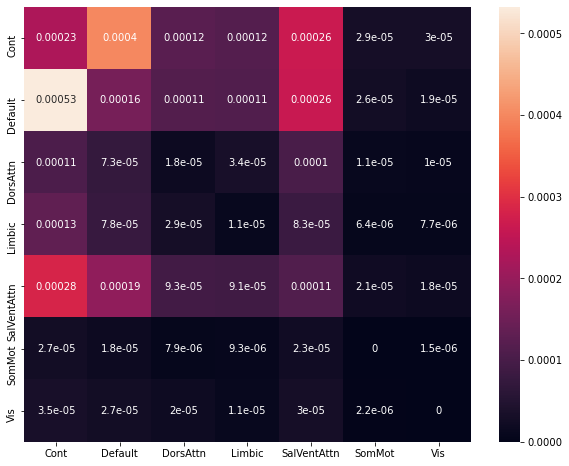

In [323]:
plt.figure(figsize=(10,8))
sns.heatmap(netMat,annot=True,xticklabels=unets,yticklabels=unets)

In [25]:
data.keys()

dict_keys(['Z_mu', 'Z_sigma', 'Z', 'S_mu', 'S_sigma', 'S', 'Z_sample100', 'S_sample100', 'recon_td_mu', 'recon_asd_mu', 'recon_twin_mu', 'recon_td_samples', 'recon_asd_samples', 'recon_twin_samples', 'Z_asd_sample10', 'S_asd_sample10'])

In [26]:
!date

Tue Mar 29 06:37:20 EDT 2022
